In [2]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


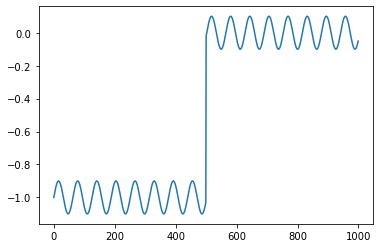

In [5]:
signal = np.sin(np.linspace(0, 100, 1000))/10
signal[:500]-=1

plt.plot(signal)

In [ ]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = n_layers
        )
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, input):
        pass